# Sentiment analysis on tweets

The goal of this project is to compare the performance of LSTM and pre-trained BERT under the limited time. When you see performance of an AI model, it often the case that it does not perform as expected for your own problem while it does for the evaluated environment.

The major reasons being
 * time is limited and do not have access to high performance cloud TPUs for optimisation
 * input data is structurally different
 * less number of labeled data are available

Here, I have 1 million sentiment labeled tweets from Stocktwit. The performance is measured in terms of accuracy and f1 score, spending a small and the same amount of time for hyperparameter tuning.

My expectation is
 * Normal LSTM can perform well on tweet type of text, as it usually does not have long complex sentence structures.
 * LSTM will overfit when the training samples are not enough but it can be trained when more inputs are avaiable
 * Pre-trained BERT has been trained Wikipedia+Book Corpus, which is quite different from tweet, thus not performing well while transfer learning is still valid

Let's see.

## Import and configurations

In [1]:
# Mount Google Drive for Colab

import sys

# Check Colab Env
IN_COLAB = 'google.colab' in sys.modules
print(IN_COLAB)

# Enter the oauth code from the link
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Set logger
import logging, time, sys
loggers = {}

def set_logger(name, level):
    global loggers

    if loggers.get(name):
        return loggers.get(name)
    else:
        logger = logging.getLogger(name)
        if (logger.hasHandlers()):
            logger.handlers.clear()
            
        logger.setLevel(level)

        timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
        formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

        fh = logging.FileHandler(name + '.log')
        # fh.setLevel(logging.DEBUG)
        fh.setFormatter(formatter)
        logger.addHandler(fh)

        ch = logging.StreamHandler(sys.stdout)
        # ch.setLevel(level)
        ch.setFormatter(formatter)
        logger.addHandler(ch)
        
        loggers[name] = logger
        return logger

logger = set_logger('sa_tweet_inperf', logging.DEBUG)

In [3]:
# Import Common modules
from tqdm.notebook import tqdm
import pickle
import os

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

# Check GPU Device
import torch
if IN_COLAB:
    logger.info("GPU Device: {}".format(torch.cuda.get_device_name(0)))

[2020-10-21 07:19:42,703][INFO] ## GPU Device: Tesla P4


In [4]:
# Note: After the following pip install, you may need to restart the kernel.
# Required modules - written here so that it can setup a new instance in Colab. Not required to run every time.
is_first = False

if IN_COLAB or is_first:
    !pip install scikit-plot transformers

In [5]:
# # Python libraries
# import datetime as dt
# import random


# # Import Scikit-learn moduels
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.pipeline import Pipeline, FeatureUnion
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn import model_selection
# from sklearn.model_selection import StratifiedKFold, learning_curve, StratifiedShuffleSplit
# from sklearn.preprocessing import LabelEncoder




In [6]:
# Set Random Seed
# random.seed(42)
# np.random.seed(42)
rand_seed = 42
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [7]:
# Specify file locations
if IN_COLAB:
    tweet_dir = 'drive/My Drive/Colab Data/'
    output_dir = 'drive/My Drive/Colab Data/'
else:
    tweet_dir = './data/tweet/'
    output_dir = './data/result/'


## Evaluation Config

### Metrics
As the data are imbalanced, use F1 score (micro) in addition to Accuracy. For cross validation, refit to F1 score.

In [8]:
# Define metrics
from sklearn.metrics import accuracy_score, f1_score
import scikitplot as skplt

# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

## Load Input Data
Tweet data from Stocktwit

In [9]:
import json

def load_tweet(filename):
    ''' Clean FinancialPhrasebank data
        Input:
            - filename
        Output:
            - a dataframe for the loaded financial phase bank data
    '''
    with open(tweet_dir + filename, 'r') as f:
        twits = json.load(f)

    logger.debug(twits['data'][:10])
    logger.info("The number of twits is: {}".format(len(twits['data'])))
    messages = [twit['message_body'] for twit in twits['data']]
    # Since the sentiment scores are discrete, we'll scale the sentiments to 0 to 4 for use in the network
    sentiments = [twit['sentiment'] + 2 for twit in twits['data']]
    
    return messages, sentiments

In [10]:
# Load data
filename = 'twits.json'
messages, sentiments = load_tweet(filename)

[2020-10-21 07:19:47,830][DEBUG] ## [{'message_body': '$FITB great buy at 26.00...ill wait', 'sentiment': 2, 'timestamp': '2018-07-01T00:00:09Z'}, {'message_body': '@StockTwits $MSFT', 'sentiment': 1, 'timestamp': '2018-07-01T00:00:42Z'}, {'message_body': '#STAAnalystAlert for $TDG : Jefferies Maintains with a rating of Hold setting target price at USD 350.00. Our own verdict is Buy  http://www.stocktargetadvisor.com/toprating', 'sentiment': 2, 'timestamp': '2018-07-01T00:01:24Z'}, {'message_body': '$AMD I heard there’s a guy who knows someone who thinks somebody knows something - on StockTwits.', 'sentiment': 1, 'timestamp': '2018-07-01T00:01:47Z'}, {'message_body': '$AMD reveal yourself!', 'sentiment': 0, 'timestamp': '2018-07-01T00:02:13Z'}, {'message_body': '$AAPL Why the drop? I warren Buffet taking out his position?', 'sentiment': 1, 'timestamp': '2018-07-01T00:03:10Z'}, {'message_body': '$BA bears have 1 reason on 06-29 to pay more attention https://dividendbot.com?s=BA', 'senti

## Process Input text

In [11]:
import re

def preprocess(message):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - tokenize by splitting the string on whitespace 
        - removes any single character tokens
    
    Parameters
    ----------
        message : The text message to be preprocessed.
        
    Returns
    -------
        tokens: The preprocessed text into tokens.
    """ 
    # Lowercase the twit message
    text = message.lower()
    
    # Replace URLs with a space in the message
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)

    # Replace everything not a letter or apostrophe with a space
    text = re.sub('[^a-zA-Z\']', ' ', text)

    # Remove single letter words
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    
    return text

In [12]:
# Check
test_message = "RT @google Our annual looked at the year in a Google's blogging (and beyond) http://t.co/sptHOAh8 $GOOG"
print(preprocess(test_message))

rt our annual looked at the year in google's blogging and beyond


In [13]:
# Process for all messages
preprocessed = [preprocess(message) for message in tqdm(messages)]

## Explore the text

In [14]:
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def tokenize_text(text, option):
    '''
    Tokenize the input text as per specified option
      1: Use python split() function
      2: Use regex to extract alphabets plus 's and 't
      3: Use NLTK word_tokenize()
      4: Use NLTK word_tokenize(), remove stop words and apply lemmatization
    '''
    if option == 1:
        return text.split()
    elif option == 2:
        return re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
    elif option == 3:
        return [word for word in word_tokenize(text) if (word.isalpha()==1)]
    elif option == 4:
        words = [word for word in word_tokenize(text) if (word.isalpha()==1)]
        # Remove stop words
        stop = set(stopwords.words('english'))
        words = [word for word in words if (word not in stop)]
        # Lemmatize words (first noun, then verb)
        wnl = nltk.stem.WordNetLemmatizer()
        lemmatized = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
        return lemmatized
    else:
        logger.warn("Please specify option value between 1 and 4")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
tokenize_text(preprocessed[0], 4)

['great', 'buy', 'ill', 'wait']


[2020-10-21 07:22:52,507][INFO] ## The number of all words: 15565855
[2020-10-21 07:22:54,542][INFO] ## The number of unique words: 105868
[2020-10-21 07:22:54,589][INFO] ## Top 40 frequent words: ['the', 'to', 'is', 'for', 'on', 'of', 'and', 'in', 'this', 'it', 'at', 'will', 'up', 'are', 'you', 'that', 'be', 'what', 'today', 'here', 'just', 'buy', 'not', 'down', 'with', 'short', 'we', 'from', 'all', 'if', 'now', 'out', 'they', 'more', 'was', 'stock', 'by', 'but', 'have', 'earnings']


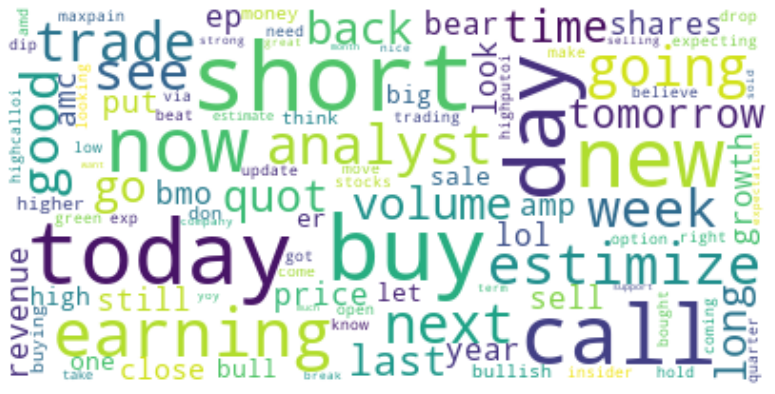

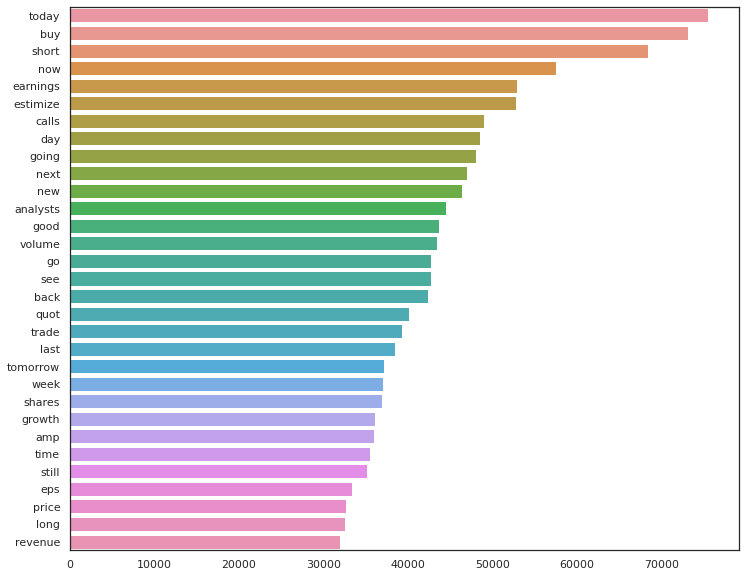

In [16]:
# Create vocab
def create_vocab(messages, show_graph=False):
    corpus = []
    for message in tqdm(messages, desc="Tokenizaing"):
        tokens = tokenize_text(message, 3) # Use option 3
        corpus.extend(tokens)
    logger.info("The number of all words: {}".format(len(corpus)))

    # Create Counter
    counts = Counter(corpus)
    logger.info("The number of unique words: {}".format(len(counts)))

    # Create BoW
    bow = sorted(counts, key=counts.get, reverse=True)
    logger.info("Top 40 frequent words: {}".format(bow[:40]))

    # Indexing vocabrary, starting from 1.
    vocab = {word: ii for ii, word in enumerate(counts, 1)}
    id2vocab = {v: k for k, v in vocab.items()}

    if show_graph:
        from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
        # Generate Word Cloud image
        text = " ".join(corpus)
        stopwords = set(STOPWORDS)
        stopwords.update(["will", "report", "reporting", "market", "stock", "share"])

        wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white", collocations=False).generate(text)
        plt.figure(figsize=(15,7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

        # Show most frequent words in a bar graph
        most = counts.most_common()[:80]
        x, y = [], []
        for word, count in most:
            if word not in stopwords:
                x.append(word)
                y.append(count)
        plt.figure(figsize=(12,10))
        sns.barplot(x=y, y=x)
        plt.show()

    return vocab

vocab= create_vocab(preprocessed, True)

## Create token id list
#token_ids = [[vocab[word] for word in text_words] for text_words in tokenized] # comment out to save memory


In [17]:
tmp_dict = {'org message': messages, 'sentence': preprocessed, 'label': sentiments}
tmp_df = pd.DataFrame(tmp_dict).sample(n=20, random_state=rand_seed)

# Samples
pd.set_option('display.max_colwidth', 200)
tmp_df

,org message,sentence,label
1377037,"$NFLX there is &#39;sell the news&#39; and there is WTF just happened counter -counter intuitive, non fuggin stop, give it to them on a platter move",there is sell the news and there is wtf just happened counter counter intuitive non fuggin stop give it to them on platter move,1
1024181,$GE $NTNX we have seen this mkt manipulation by hedge funds thru fake news and/or WS lowlife spokesperson like tusa.,we have seen this mkt manipulation by hedge funds thru fake news and or ws lowlife spokesperson like tusa,3
944591,$CHK Bought in. Like the way this chart is heading towards.,bought in like the way this chart is heading towards,3
1086704,$NKE can&#39;t make a good quality shoe...so they divert attention to politics..they find out they aren&#39;t good at either...,can make good quality shoe so they divert attention to politics they find out they aren good at either,2
126458,"$AMZN big guys got out, bull tards left holding a serious bag of testicles",big guys got out bull tards left holding serious bag of testicles,1
230284,$MU congrats to those who followed my call and shorted this at 55.4 👍🏻,congrats to those who followed my call and shorted this at,0
830349,"$AMZN 1950 puts still looking good for tomorrow, honestly expected a higher push before lower lows",puts still looking good for tomorrow honestly expected higher push before lower lows,3
882668,$AVGO should I be adding here?? Options please,should be adding here options please,3
1059772,$MCD if you don&#39;t buy this you hate America.,if you don buy this you hate america,3
657245,$EXPE&#39;s Room Nights Growth is a key growth metric for their next report on 10/25 AMC. Will they beat last quarter&#39;s 12.0% Room Nights G...\nhttp://www.estimize.com/intro/expe?chart=histori...,room nights growth is key growth metric for their next report on amc will they beat last quarter room nights,3


In [18]:
# Change the table display config back
pd.set_option('display.max_colwidth', 50)

## Data Selection


[2020-10-21 07:25:47,237][INFO] ## The total number of input data: 1194522


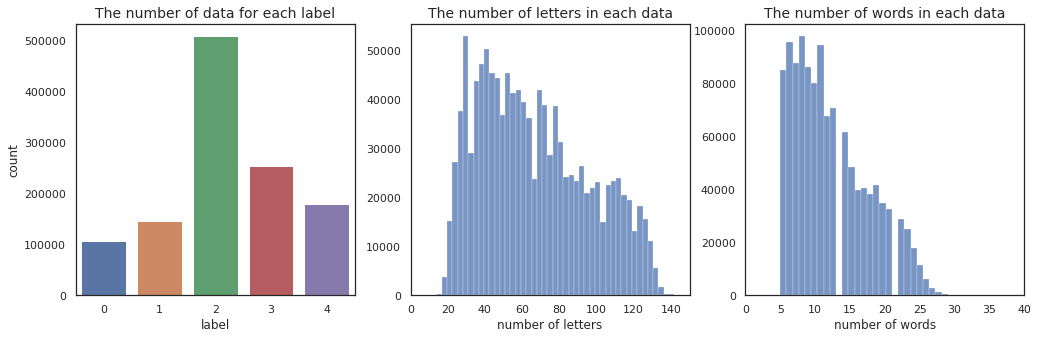

In [19]:
# Create a dataframe for training data
word_cnt = [len(tokenize_text(x, 3)) for x in tqdm(preprocessed)]

# Use tweets having 5 or more words. Do not resample for balancing data here.
train_dict = {'text': preprocessed, 'label': sentiments, 'count': word_cnt}
train_df = pd.DataFrame(train_dict)
train_df = train_df.loc[train_df['count'] >= 5]
train_df.reset_index(drop=True, inplace=True)
logger.info("The total number of input data: {}".format(len(train_df)))

# Display the distribution graph
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(17,5))
sns.countplot(x='label', data=train_df, ax=ax1)
ax1.set_title('The number of data for each label', fontsize=14)
sns.histplot([len(x) for x in train_df['text']], ax=ax2, bins=100)
ax2.set_title('The number of letters in each data', fontsize=14)
ax2.set_xlim(0,150)
ax2.set_xlabel('number of letters')
ax2.set_ylabel("")
sns.histplot(train_df['count'], ax=ax3, bins=100)
ax3.set_title('The number of words in each data', fontsize=14)
ax3.set_xlim(0,40)
ax3.set_xlabel('number of words')
ax3.set_ylabel("")

plt.show()

# Define Models

In [20]:
# Import Pytorch modules
# import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader, TensorDataset, Dataset

from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from transformers import AdamW as AdamW_HF, get_linear_schedule_with_warmup

## Dataset

In [21]:
# Define a DataSet Class which simply return (x, y) pair
class SimpleDataset(Dataset):
    def __init__(self, x, y):
        self.datalist=[(x[i], y[i]) for i in range(len(y))]
    def __len__(self):
        return len(self.datalist)
    def __getitem__(self,idx):
        return self.datalist[idx]

In [22]:
# Data Loader
def create_data_loader(X, y, indices, batch_size, shuffle):
    X_sampled = np.array(X, dtype=object)[indices]
    y_sampled = np.array(y)[indices].astype(int)
    dataset = SimpleDataset(X_sampled, y_sampled)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

## Training Process

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit

def train_cycles(X_all, y_all, vocab, num_samples, model_type, epochs, patience, batch_size, seq_len, lr, clip, log_level):
    result = pd.DataFrame(columns=['Accuracy', 'F1(macro)', 'Total_Time', 'ms/text'], index=num_samples)

    for n in num_samples:
        print("")
        logger.info("############### Start training for %d samples ###############" %n)

        # Stratified sampling
        train_size = n / len(y_all)
        sss = StratifiedShuffleSplit(n_splits=1, train_size=train_size, test_size=train_size*0.2 , random_state=rand_seed)
        train_indices, valid_indices = next(sss.split(X_all, y_all))

        # Sample input data
        train_loader = create_data_loader(X_all, y_all, train_indices, batch_size, True)
        valid_loader = create_data_loader(X_all, y_all, valid_indices, batch_size, False)

        if model_type == 'LSTM':
            model = TextClassifier(len(vocab)+1, embed_size=512, lstm_size=1289, dense_size=0, output_size=5, lstm_layers=4, dropout=0.2)
            model.embedding.weight.data.uniform_(-1, 1)
        elif model_type == 'BERT':
            model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

        start_time = time.perf_counter() # use time.process_time() for CPU time
        acc, f1, model_trained = train_nn_model(model, model_type, train_loader, valid_loader, vocab, epochs, patience, batch_size, seq_len, lr, clip, log_level)
        end_time = time.perf_counter() # use time.process_time() for CPU time
        duration = end_time - start_time
        logger.info("Process Time (sec): {}".format(duration))
        result.loc[n] = (round(acc,4), round(f1,4), duration, duration/n*1000)

    return result, model_trained

In [33]:
def train_nn_model(model, model_type, train_loader, valid_loader, vocab, epochs, patience, batch_size, seq_len, lr, clip, log_level):
    # Set variables
    logger = set_logger('sa_tweet_inperf', log_level)
    num_total_opt_steps = int(len(train_loader) * epochs)
    eval_every = len(train_loader) // 5
    warm_up_proportion = 0.1
    logger.info('Total Training Steps: {} ({} batches x {} epochs)'.format(num_total_opt_steps, len(train_loader), epochs))

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = AdamW_HF(model.parameters(), lr=lr, correct_bias=False) 
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_total_opt_steps*warm_up_proportion, num_training_steps=num_total_opt_steps)  # PyTorch scheduler
    criterion = nn.NLLLoss()

    # Set Train Mode
    model.train()

    # Initialise
    acc_train, f1_train, loss_train, acc_valid, f1_valid, loss_valid = [], [], [], [], [], []
    best_f1, early_stop, steps = 0, 0, 0
    class_names = ['0:Very Negative','1:Negative', '2:Neutral', '3:Positive', '4:Very Positive']

    for epoch in tqdm(range(epochs), desc="Epoch"):
        logger.info('================     epoch {}     ==============='.format(epoch+1))

        #################### Training ####################
        # Initialise
        loss_tmp = 0.
        y_pred_tmp, y_truth_tmp = [], []
        hidden = model.init_hidden(batch_size) if model_type == "LSTM" else None

        for i, batch in enumerate(train_loader):
            text_batch, labels = batch
            # Skip the last batch of which size is not equal to batch_size
            if labels.size(0) != batch_size:
                break
            steps += 1
           
            # Reset gradient
            model.zero_grad()
            optimizer.zero_grad()

            # Initialise after the previous training
            if steps % eval_every == 1:
                loss_tmp = 0.
                y_pred_tmp, y_truth_tmp = [], []

            if model_type == "LSTM":
                # Tokenize the input and move to device
                text_batch = tokenizer_lstm(text_batch, vocab, seq_len, padding='left').transpose(1,0).to(device)
                labels = torch.tensor(labels, dtype=torch.int64).to(device)

                # Creating new variables for the hidden state to avoid backprop entire training history
                hidden = tuple([each.data for each in hidden])
                for each in hidden:
                    each.to(device)

                # Get output and hidden state from the model, calculate the loss
                logits, hidden = model(text_batch, hidden)
                loss = criterion(logits, labels)
                
            elif model_type == 'BERT':
                # Tokenize the input and move to device
                # Tokenizer Parameter
                param_tk = {
                    'return_tensors': "pt",
                    'padding': 'max_length',
                    'max_length': seq_len,
                    'add_special_tokens': True,
                    'truncation': True
                }
                text_batch = tokenizer_bert(text_batch, **param_tk).to(device)
                labels = torch.tensor(labels, dtype=torch.int64).to(device)

                # Feedforward prediction
                loss, logits = model(**text_batch, labels=labels)

            y_pred_tmp.extend(np.argmax(F.softmax(logits, dim=1).cpu().detach().numpy(), axis=1))
            y_truth_tmp.extend(labels.cpu().numpy())

            # Back prop
            loss.backward()

            # Training Loss
            loss_tmp += loss.item() / len(train_loader)

            # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
            nn.utils.clip_grad_norm_(model.parameters(), clip)

            # Update Weights and Learning Rate
            optimizer.step()
            scheduler.step()


            #################### Evaluation ####################
            if (steps % eval_every == 0) or ((steps % eval_every != 0) and (steps == len(train_loader))):
                # Evaluate Training
                acc, f1 = metric(y_truth_tmp, y_pred_tmp)
                acc_train.append(acc)
                f1_train.append(f1)
                loss_train.append(loss_tmp)

                # Initialise for validation
                loss_tmp = 0.
                # y_pred_tmp = np.zeros((len(y_valid), 5))
                y_truth_tmp, y_pred_tmp = [], []

                # Move to Evaluation Mode
                model.eval()

                with torch.no_grad():
                    for i, batch in enumerate(valid_loader):
                        text_batch, labels = batch
                        # Skip the last batch of which size is not equal to batch_size
                        if labels.size(0) != batch_size:
                            break

                        if model_type == "LSTM":
                            # Tokenize the input and move to device
                            text_batch = tokenizer_lstm(text_batch, vocab, seq_len, padding='left').transpose(1,0).to(device)
                            labels = torch.tensor(labels, dtype=torch.int64).to(device)

                            # Creating new variables for the hidden state to avoid backprop entire training history
                            hidden = tuple([each.data for each in hidden])
                            for each in hidden:
                                each.to(device)

                            # Get output and hidden state from the model, calculate the loss
                            logits, hidden = model(text_batch, hidden)
                            loss = criterion(logits, labels)
                
                        elif model_type == 'BERT':
                            # Tokenize the input and move to device
                            text_batch = tokenizer_bert(text_batch, **param_tk).to(device)
                            labels = torch.tensor(labels, dtype=torch.int64).to(device)
                            # Feedforward prediction
                            loss, logits = model(**text_batch, labels=labels)
                    
                        loss_tmp += loss.item() / len(valid_loader)
                        y_pred_tmp.extend(np.argmax(F.softmax(logits, dim=1).cpu().detach().numpy(), axis=1))
                        y_truth_tmp.extend(labels.cpu().numpy())
                        # logger.debug('validation batch: {}, val_loss: {}'.format(i, loss.item() / len(valid_loader)))

                acc, f1 = metric(y_truth_tmp, y_pred_tmp)
                logger.debug("Epoch: {}/{}, Step: {}, Loss: {:.4f}, Acc: {:.4f}, F1: {:.4f}".format(epoch+1, epochs, steps, loss_tmp, acc, f1))
                acc_valid.append(acc)
                f1_valid.append(f1)
                loss_valid.append(loss_tmp)

                # Back to train mode
                model.train()

        #################### End of each epoch ####################

        # Show the last evaluation metrics
        logger.info('epoch: %d, last train loss: %.4f, last valid loss: %.4f' % (epoch+1, loss_train[-1], loss_valid[-1]))
        logger.info('last acc: %.4f, last f1: %.4f, best_f1: %.4f, last lr: %.6f' % (acc_valid[-1], f1_valid[-1], best_f1, scheduler.get_last_lr()[0]))

        # Plot Confusion Matrix
        y_truth_class = [class_names[int(idx)] for idx in y_truth_tmp]
        y_predicted_class = [class_names[int(idx)] for idx in y_pred_tmp]
        
        titles_options = [("Actual Count", None), ("Normalised", 'true')]
        for title, normalize in titles_options:
            disp = skplt.metrics.plot_confusion_matrix(y_truth_class, y_predicted_class, normalize=normalize, title=title, x_tick_rotation=75)
        plt.show()

        # plot training performance
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
        ax1.set_title("Losses")
        ax1.set_xlabel("Validation Cycle")
        ax1.set_ylabel("Loss")
        ax1.plot(loss_train, 'b-o', label='Train Loss')
        ax1.plot(loss_valid, 'r-o', label='Valid Loss')
        ax1.legend(loc="upper right")
        
        ax2.set_title("Evaluation")
        ax2.set_xlabel("Validation Cycle")
        ax2.set_ylabel("Score")
        ax2.set_ylim(0,1)
        ax2.plot(acc_train, 'y-o', label='Accuracy (train)')
        ax2.plot(f1_train, 'y--', label='F1 Score (train)')
        ax2.plot(acc_valid, 'g-o', label='Accuracy (valid)')
        ax2.plot(f1_valid, 'g--', label='F1 Score (valid)')
        ax2.legend(loc="upper right")

        plt.show()

        # If improving, save the number. If not, count up for early stopping
        if best_f1 < f1_valid[-1]:
            early_stop = 0
            best_f1 = f1_valid[-1]
        else:
            early_stop += 1

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

        # Prepare for the next epoch
        if device == 'cuda:0':
            torch.cuda.empty_cache()
        model.train()

    return acc, f1, model


## LSTM (RNN)
Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.

<table><tr><td><img src="./docs/lstm_4.png" width=450></td><td><img src="./docs/lstm_1.png" width=300></td></tr></table>


In [26]:
# Define LSTM Model
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, dense_size, output_size, lstm_layers=2, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.dense_size = dense_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(dropout)

        if dense_size == 0:
            self.fc = nn.Linear(lstm_size, output_size)
        else:
            self.fc1 = nn.Linear(lstm_size, dense_size)
            self.fc2 = nn.Linear(dense_size, output_size)

        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
                
        return hidden

    def forward(self, nn_input_text, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        if self.dense_size == 0:
            out = self.fc(lstm_out)
        else:
            dense_out = self.fc1(lstm_out)
            out = self.fc2(dense_out)
        # Softmax
        logps = self.softmax(out)

        return logps, hidden_state

In [27]:
# Define a tokenizer
def tokenizer_lstm(X, vocab, seq_len, padding):
    X_tmp = np.zeros((len(X), seq_len), dtype=np.int64)
    for i, text in enumerate(X):
        tokens = tokenize_text(text, 3) 
        token_ids = [vocab[word] for word in tokens]
        end_idx = min(len(token_ids), seq_len)
        if padding == 'right':
            X_tmp[i,:end_idx] = token_ids[:end_idx]
        elif padding == 'left':
            start_idx = max(seq_len - len(token_ids), 0)
            X_tmp[i,start_idx:] = token_ids[:end_idx]

    return torch.tensor(X_tmp, dtype=torch.int64)

### Configure the model and train!

[2020-10-21 07:41:48,502][INFO] ## 
Start training for 1000 samples
[2020-10-21 07:41:50,040][INFO] ## Total Training Steps: 80 (16 batches x 5 epochs)


[2020-10-21 07:41:50,173][INFO] ## ================     epoch 1     ===============


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2020-10-21 07:41:51,173][DEBUG] ## Epoch: 1/5, Step: 3, Loss: 1.1792, Acc: 0.4271, F1: 0.1197
[2020-10-21 07:41:52,161][DEBUG] ## Epoch: 1/5, Step: 6, Loss: 2.1788, Acc: 0.4271, F1: 0.1197
[2020-10-21 07:41:53,164][DEBUG] ## Epoch: 1/5, Step: 9, Loss: 1.1184, Acc: 0.4271, F1: 0.1197
[2020-10-21 07:41:54,163][DEBUG] ## Epoch: 1/5, Step: 12, Loss: 1.0863, Acc: 0.4271, F1: 0.1197
[2020-10-21 07:41:55,163][DEBUG] ## Epoch: 1/5, Step: 15, Loss: 1.0768, Acc: 0.4271, F1: 0.1197
[2020-10-21 07:41:55,165][INFO] ## epoch: 1, last train loss: 0.2683, last valid loss: 1.0768
[2020-10-21 07:41:55,166][INFO] ## last acc: 0.4271, last f1: 0.1197, best_f1: 0.0000, last lr: 0.000271


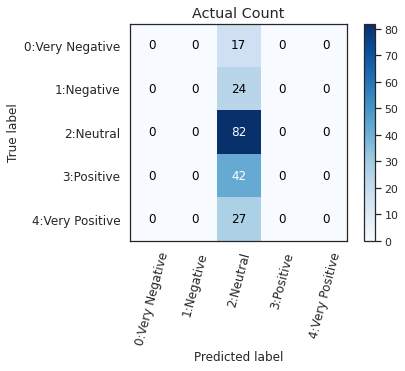

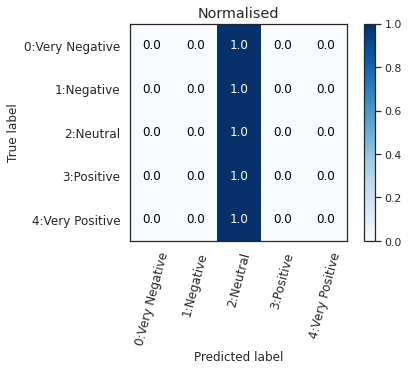

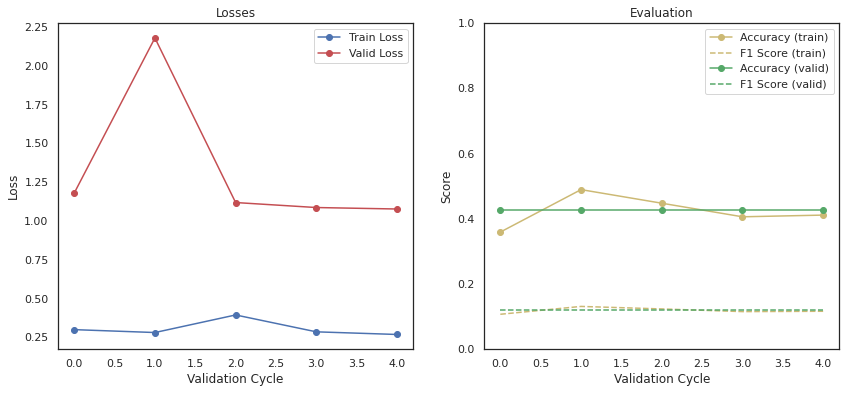

[2020-10-21 07:41:56,155][INFO] ## ================     epoch 2     ===============
[2020-10-21 07:41:56,642][DEBUG] ## Epoch: 2/5, Step: 16, Loss: 1.0797, Acc: 0.3906, F1: 0.1275
[2020-10-21 07:41:57,373][DEBUG] ## Epoch: 2/5, Step: 18, Loss: 1.0914, Acc: 0.4062, F1: 0.1810
[2020-10-21 07:41:58,370][DEBUG] ## Epoch: 2/5, Step: 21, Loss: 1.0786, Acc: 0.4271, F1: 0.1197
[2020-10-21 07:41:59,372][DEBUG] ## Epoch: 2/5, Step: 24, Loss: 1.0806, Acc: 0.4271, F1: 0.1201
[2020-10-21 07:42:00,381][DEBUG] ## Epoch: 2/5, Step: 27, Loss: 1.0881, Acc: 0.4010, F1: 0.1237
[2020-10-21 07:42:01,384][DEBUG] ## Epoch: 2/5, Step: 30, Loss: 1.1024, Acc: 0.4167, F1: 0.1199
[2020-10-21 07:42:01,385][INFO] ## epoch: 2, last train loss: 0.2586, last valid loss: 1.1024
[2020-10-21 07:42:01,386][INFO] ## last acc: 0.4167, last f1: 0.1199, best_f1: 0.1197, last lr: 0.000208


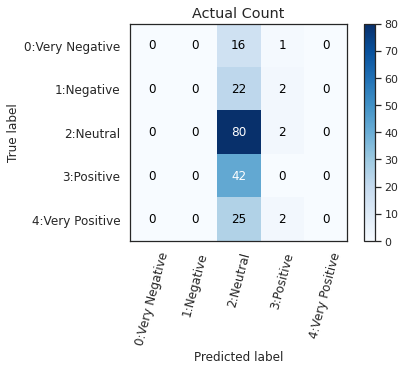

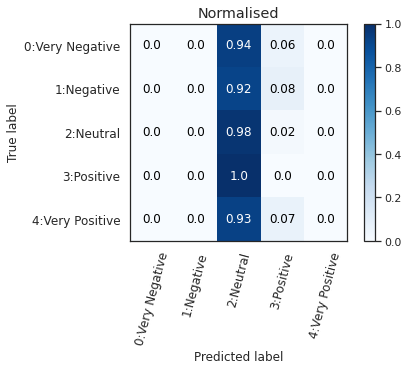

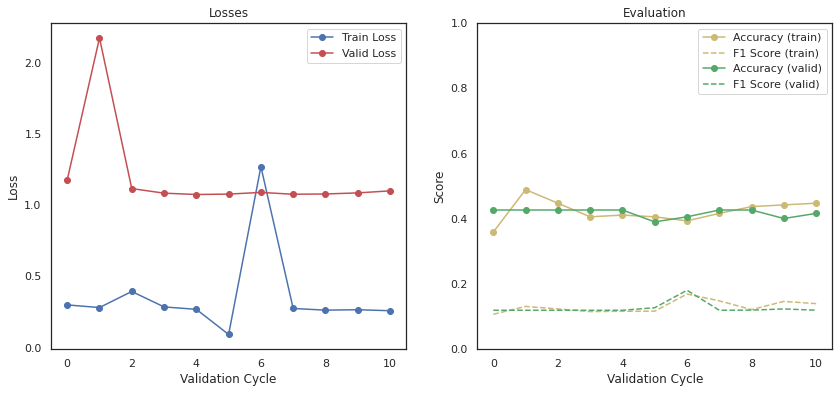

[2020-10-21 07:42:02,321][INFO] ## ================     epoch 3     ===============
[2020-10-21 07:42:03,330][DEBUG] ## Epoch: 3/5, Step: 33, Loss: 1.0799, Acc: 0.4010, F1: 0.2381
[2020-10-21 07:42:04,326][DEBUG] ## Epoch: 3/5, Step: 36, Loss: 1.1125, Acc: 0.4271, F1: 0.2330
[2020-10-21 07:42:05,317][DEBUG] ## Epoch: 3/5, Step: 39, Loss: 1.0851, Acc: 0.3906, F1: 0.2478
[2020-10-21 07:42:06,309][DEBUG] ## Epoch: 3/5, Step: 42, Loss: 1.0568, Acc: 0.3802, F1: 0.2213
[2020-10-21 07:42:07,305][DEBUG] ## Epoch: 3/5, Step: 45, Loss: 1.0403, Acc: 0.4219, F1: 0.2514
[2020-10-21 07:42:07,306][INFO] ## epoch: 3, last train loss: 0.2394, last valid loss: 1.0403
[2020-10-21 07:42:07,307][INFO] ## last acc: 0.4219, last f1: 0.2514, best_f1: 0.1199, last lr: 0.000146


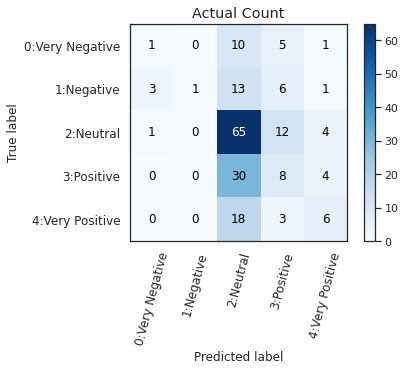

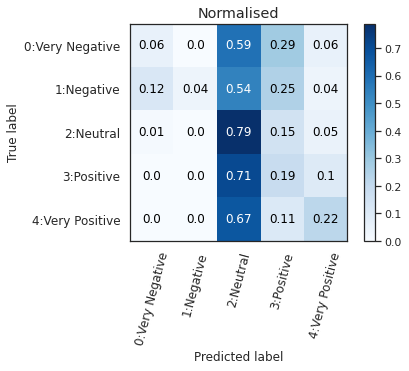

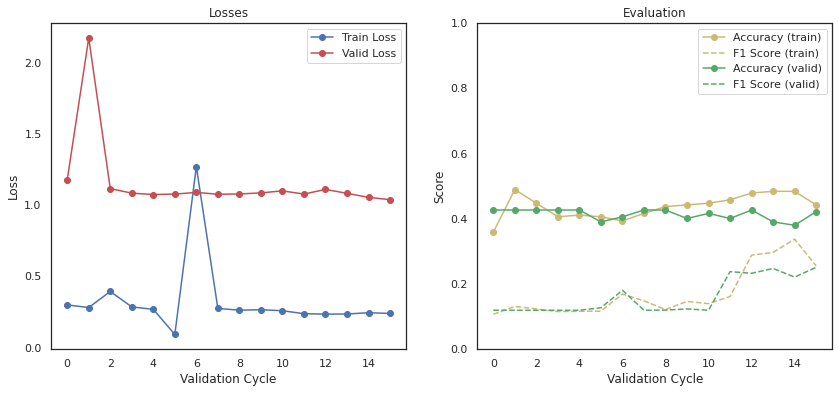

[2020-10-21 07:42:08,252][INFO] ## ================     epoch 4     ===============
[2020-10-21 07:42:09,262][DEBUG] ## Epoch: 4/5, Step: 48, Loss: 1.0764, Acc: 0.4271, F1: 0.2761
[2020-10-21 07:42:10,272][DEBUG] ## Epoch: 4/5, Step: 51, Loss: 1.1174, Acc: 0.4427, F1: 0.2808
[2020-10-21 07:42:11,274][DEBUG] ## Epoch: 4/5, Step: 54, Loss: 1.1029, Acc: 0.4427, F1: 0.3102
[2020-10-21 07:42:12,277][DEBUG] ## Epoch: 4/5, Step: 57, Loss: 1.0989, Acc: 0.4115, F1: 0.3171
[2020-10-21 07:42:13,281][DEBUG] ## Epoch: 4/5, Step: 60, Loss: 1.0770, Acc: 0.4375, F1: 0.3584
[2020-10-21 07:42:13,282][INFO] ## epoch: 4, last train loss: 0.2073, last valid loss: 1.0770
[2020-10-21 07:42:13,288][INFO] ## last acc: 0.4375, last f1: 0.3584, best_f1: 0.2514, last lr: 0.000083


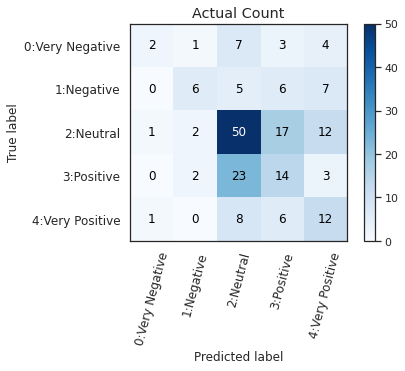

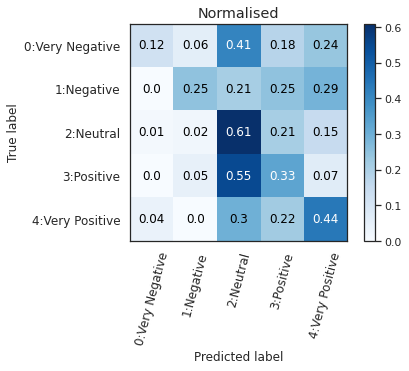

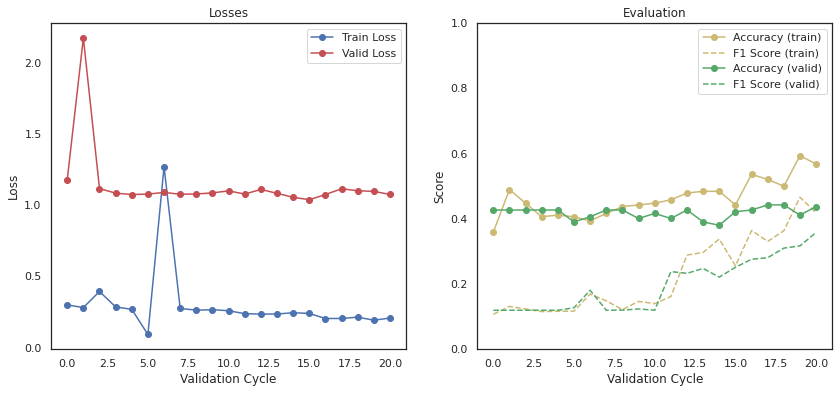

[2020-10-21 07:42:14,255][INFO] ## ================     epoch 5     ===============
[2020-10-21 07:42:15,262][DEBUG] ## Epoch: 5/5, Step: 63, Loss: 1.0697, Acc: 0.4167, F1: 0.3377
[2020-10-21 07:42:16,260][DEBUG] ## Epoch: 5/5, Step: 66, Loss: 1.0906, Acc: 0.4271, F1: 0.3595
[2020-10-21 07:42:17,254][DEBUG] ## Epoch: 5/5, Step: 69, Loss: 1.1384, Acc: 0.4219, F1: 0.3552
[2020-10-21 07:42:18,255][DEBUG] ## Epoch: 5/5, Step: 72, Loss: 1.1509, Acc: 0.4375, F1: 0.3707
[2020-10-21 07:42:19,256][DEBUG] ## Epoch: 5/5, Step: 75, Loss: 1.1577, Acc: 0.4427, F1: 0.3737
[2020-10-21 07:42:19,257][INFO] ## epoch: 5, last train loss: 0.1605, last valid loss: 1.1577
[2020-10-21 07:42:19,258][INFO] ## last acc: 0.4427, last f1: 0.3737, best_f1: 0.3584, last lr: 0.000021


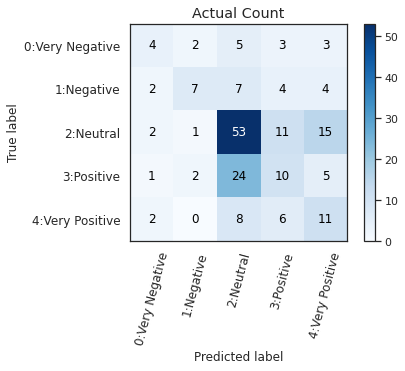

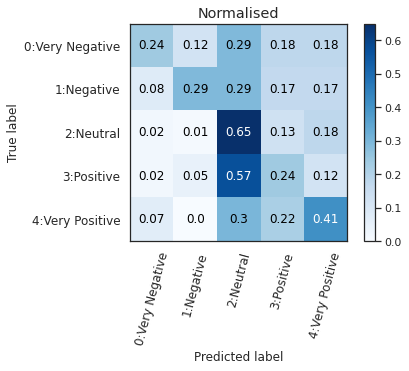

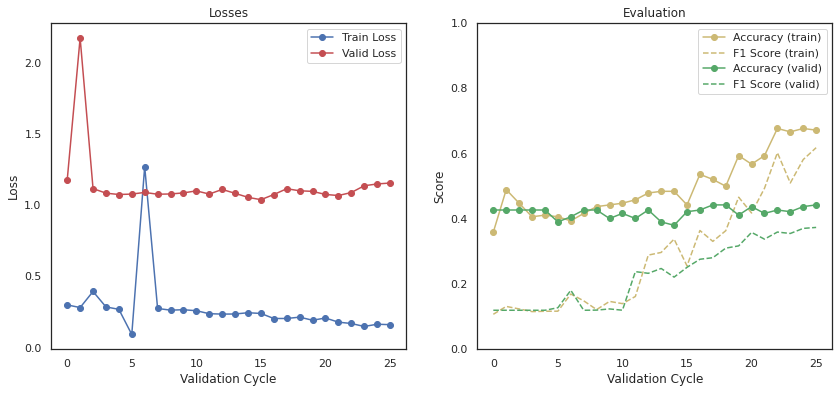


[2020-10-21 07:42:20,176][INFO] ## Process Time (sec): 30.135893915999986
[2020-10-21 07:42:20,180][INFO] ## 
Start training for 5000 samples
[2020-10-21 07:42:21,698][INFO] ## Total Training Steps: 395 (79 batches x 5 epochs)


[2020-10-21 07:42:21,829][INFO] ## ================     epoch 1     ===============


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2020-10-21 07:42:26,812][DEBUG] ## Epoch: 1/5, Step: 15, Loss: 1.4308, Acc: 0.4302, F1: 0.1203
[2020-10-21 07:42:31,802][DEBUG] ## Epoch: 1/5, Step: 30, Loss: 3.2139, Acc: 0.1708, F1: 0.1182
[2020-10-21 07:42:36,807][DEBUG] ## Epoch: 1/5, Step: 45, Loss: 1.3249, Acc: 0.4396, F1: 0.1687
[2020-10-21 07:42:41,827][DEBUG] ## Epoch: 1/5, Step: 60, Loss: 1.2989, Acc: 0.4302, F1: 0.1203
[2020-10-21 07:42:46,833][DEBUG] ## Epoch: 1/5, Step: 75, Loss: 1.2507, Acc: 0.4448, F1: 0.1904
[2020-10-21 07:42:47,583][INFO] ## epoch: 1, last train loss: 0.2606, last valid loss: 1.2507
[2020-10-21 07:42:47,583][INFO] ## last acc: 0.4448, last f1: 0.1904, best_f1: 0.0000, last lr: 0.000268


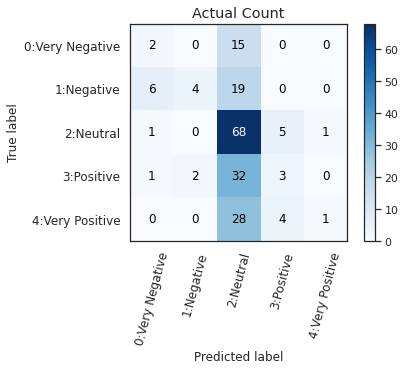

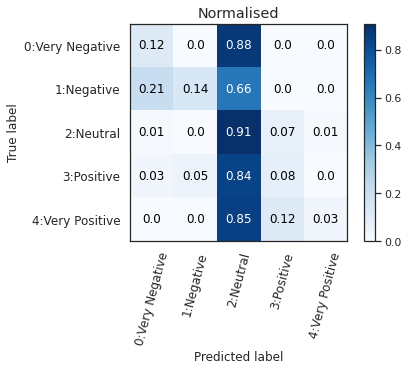

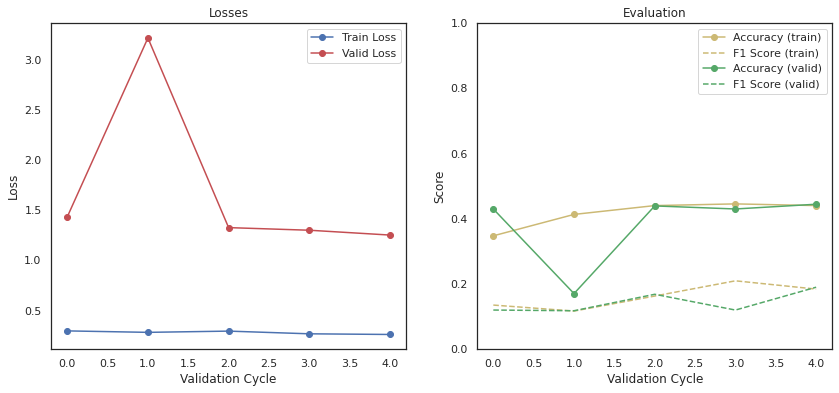

[2020-10-21 07:42:48,581][INFO] ## ================     epoch 2     ===============
[2020-10-21 07:42:49,933][DEBUG] ## Epoch: 2/5, Step: 79, Loss: 1.2538, Acc: 0.4521, F1: 0.2797
[2020-10-21 07:42:53,915][DEBUG] ## Epoch: 2/5, Step: 90, Loss: 1.2277, Acc: 0.4760, F1: 0.3245
[2020-10-21 07:42:58,935][DEBUG] ## Epoch: 2/5, Step: 105, Loss: 1.2672, Acc: 0.4604, F1: 0.2744
[2020-10-21 07:43:03,975][DEBUG] ## Epoch: 2/5, Step: 120, Loss: 1.2754, Acc: 0.4854, F1: 0.3495
[2020-10-21 07:43:09,004][DEBUG] ## Epoch: 2/5, Step: 135, Loss: 1.1987, Acc: 0.4969, F1: 0.3561
[2020-10-21 07:43:14,065][DEBUG] ## Epoch: 2/5, Step: 150, Loss: 1.1599, Acc: 0.5188, F1: 0.3659
[2020-10-21 07:43:15,617][INFO] ## epoch: 2, last train loss: 0.2298, last valid loss: 1.1599
[2020-10-21 07:43:15,618][INFO] ## last acc: 0.5188, last f1: 0.3659, best_f1: 0.1904, last lr: 0.000202


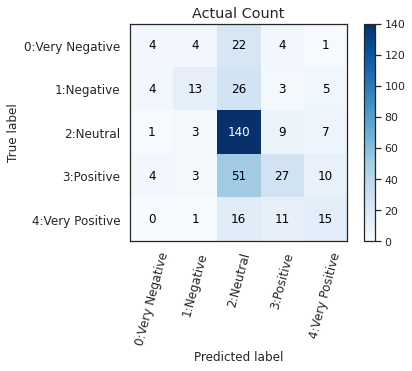

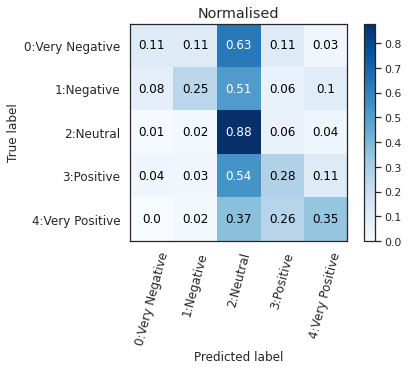

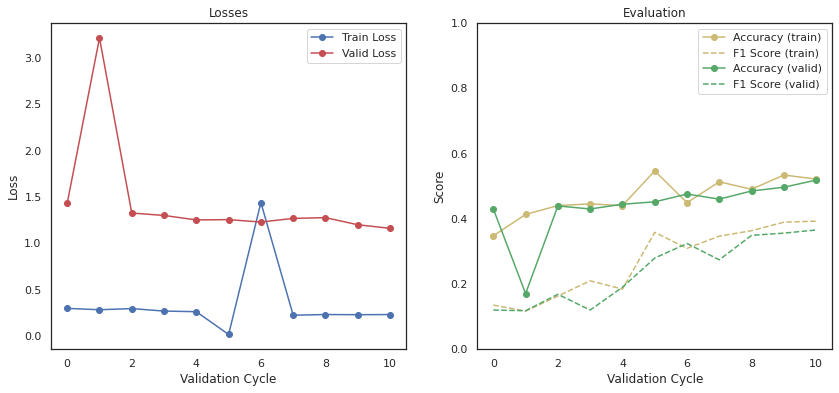

[2020-10-21 07:43:16,577][INFO] ## ================     epoch 3     ===============
[2020-10-21 07:43:20,050][DEBUG] ## Epoch: 3/5, Step: 165, Loss: 1.1636, Acc: 0.4948, F1: 0.4049
[2020-10-21 07:43:25,101][DEBUG] ## Epoch: 3/5, Step: 180, Loss: 1.2182, Acc: 0.4448, F1: 0.3881
[2020-10-21 07:43:30,170][DEBUG] ## Epoch: 3/5, Step: 195, Loss: 1.2182, Acc: 0.5000, F1: 0.4239
[2020-10-21 07:43:35,260][DEBUG] ## Epoch: 3/5, Step: 210, Loss: 1.1946, Acc: 0.5021, F1: 0.4201
[2020-10-21 07:43:40,367][DEBUG] ## Epoch: 3/5, Step: 225, Loss: 1.2198, Acc: 0.4917, F1: 0.4188
[2020-10-21 07:43:42,726][INFO] ## epoch: 3, last train loss: 0.1757, last valid loss: 1.2198
[2020-10-21 07:43:42,727][INFO] ## last acc: 0.4917, last f1: 0.4188, best_f1: 0.3659, last lr: 0.000136


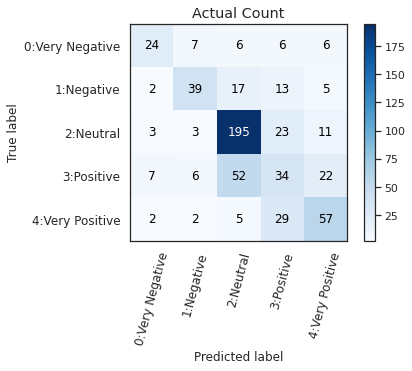

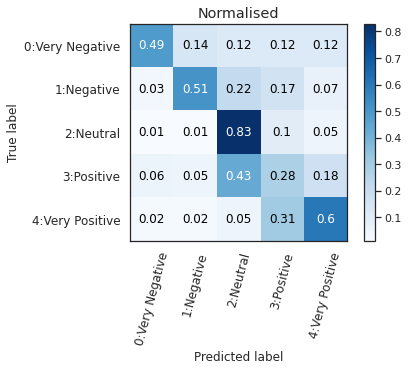

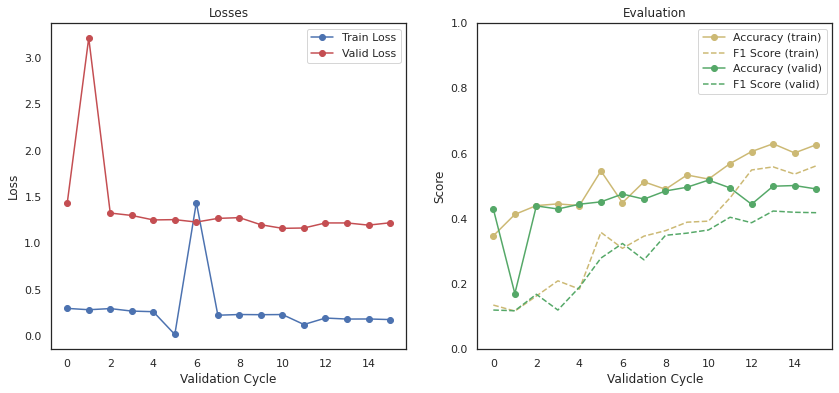

[2020-10-21 07:43:44,078][INFO] ## ================     epoch 4     ===============
[2020-10-21 07:43:46,772][DEBUG] ## Epoch: 4/5, Step: 240, Loss: 1.1893, Acc: 0.4979, F1: 0.4410
[2020-10-21 07:43:51,887][DEBUG] ## Epoch: 4/5, Step: 255, Loss: 1.3428, Acc: 0.4885, F1: 0.4188
[2020-10-21 07:43:56,979][DEBUG] ## Epoch: 4/5, Step: 270, Loss: 1.2638, Acc: 0.4865, F1: 0.4239
[2020-10-21 07:44:02,071][DEBUG] ## Epoch: 4/5, Step: 285, Loss: 1.3582, Acc: 0.5062, F1: 0.4403
[2020-10-21 07:44:07,193][DEBUG] ## Epoch: 4/5, Step: 300, Loss: 1.2759, Acc: 0.5021, F1: 0.4502
[2020-10-21 07:44:10,359][INFO] ## epoch: 4, last train loss: 0.1376, last valid loss: 1.2759
[2020-10-21 07:44:10,360][INFO] ## last acc: 0.5021, last f1: 0.4502, best_f1: 0.4188, last lr: 0.000070


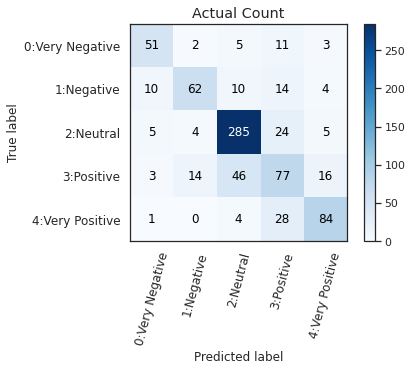

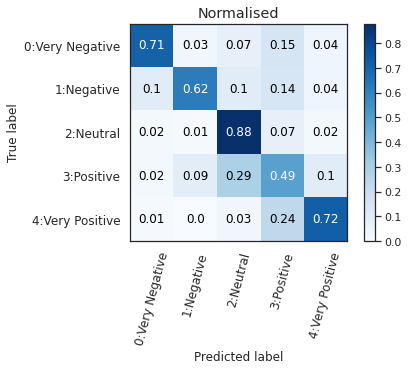

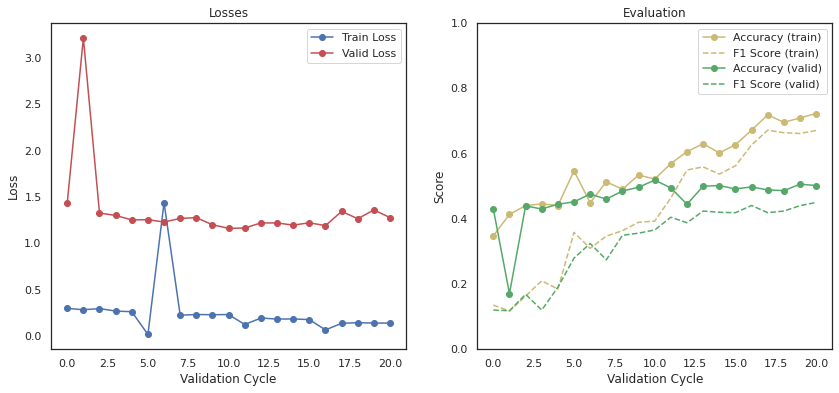

[2020-10-21 07:44:11,314][INFO] ## ================     epoch 5     ===============
[2020-10-21 07:44:13,214][DEBUG] ## Epoch: 5/5, Step: 315, Loss: 1.2963, Acc: 0.4979, F1: 0.4351
[2020-10-21 07:44:18,333][DEBUG] ## Epoch: 5/5, Step: 330, Loss: 1.3860, Acc: 0.5177, F1: 0.4602
[2020-10-21 07:44:23,448][DEBUG] ## Epoch: 5/5, Step: 345, Loss: 1.4392, Acc: 0.5052, F1: 0.4550
[2020-10-21 07:44:28,557][DEBUG] ## Epoch: 5/5, Step: 360, Loss: 1.4914, Acc: 0.5000, F1: 0.4479
[2020-10-21 07:44:33,670][DEBUG] ## Epoch: 5/5, Step: 375, Loss: 1.5156, Acc: 0.4990, F1: 0.4472
[2020-10-21 07:44:38,777][DEBUG] ## Epoch: 5/5, Step: 390, Loss: 1.5132, Acc: 0.4969, F1: 0.4448
[2020-10-21 07:44:38,778][INFO] ## epoch: 5, last train loss: 0.0957, last valid loss: 1.5132
[2020-10-21 07:44:38,780][INFO] ## last acc: 0.4969, last f1: 0.4448, best_f1: 0.4502, last lr: 0.000004


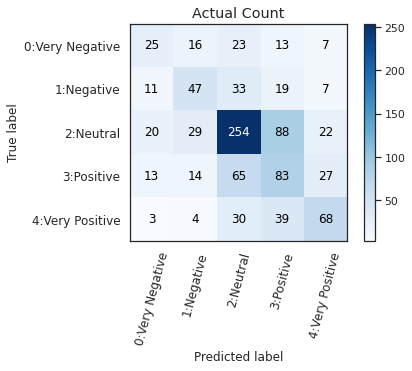

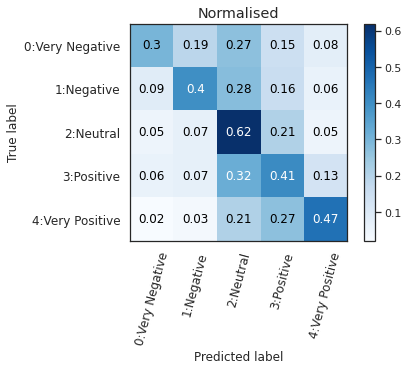

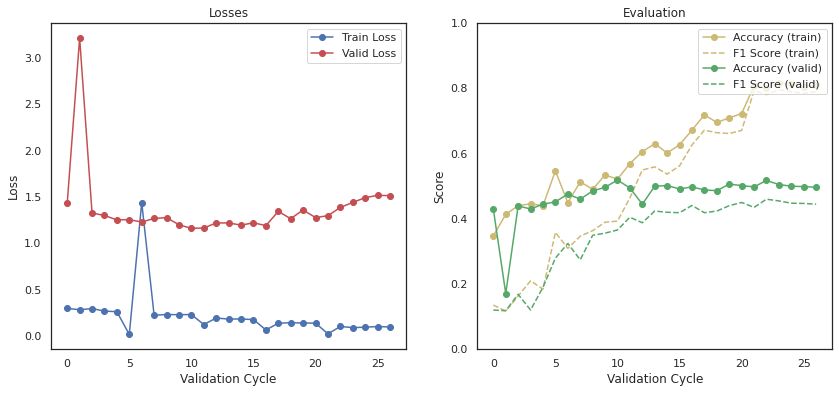


[2020-10-21 07:44:39,754][INFO] ## Process Time (sec): 138.05573483800072
[2020-10-21 07:44:39,757][INFO] ## 
Start training for 10000 samples
[2020-10-21 07:44:41,299][INFO] ## Total Training Steps: 785 (157 batches x 5 epochs)


[2020-10-21 07:44:41,425][INFO] ## ================     epoch 1     ===============


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2020-10-21 07:44:51,955][DEBUG] ## Epoch: 1/5, Step: 31, Loss: 1.3819, Acc: 0.4284, F1: 0.1374
[2020-10-21 07:45:02,490][DEBUG] ## Epoch: 1/5, Step: 62, Loss: 1.4255, Acc: 0.3881, F1: 0.2198
[2020-10-21 07:45:13,066][DEBUG] ## Epoch: 1/5, Step: 93, Loss: 1.2930, Acc: 0.4632, F1: 0.2581
[2020-10-21 07:45:23,653][DEBUG] ## Epoch: 1/5, Step: 124, Loss: 1.2402, Acc: 0.4758, F1: 0.2705
[2020-10-21 07:45:34,236][DEBUG] ## Epoch: 1/5, Step: 155, Loss: 1.2031, Acc: 0.5030, F1: 0.3299
[2020-10-21 07:45:34,465][INFO] ## epoch: 1, last train loss: 0.2476, last valid loss: 1.2031
[2020-10-21 07:45:34,466][INFO] ## last acc: 0.5030, last f1: 0.3299, best_f1: 0.0000, last lr: 0.000267


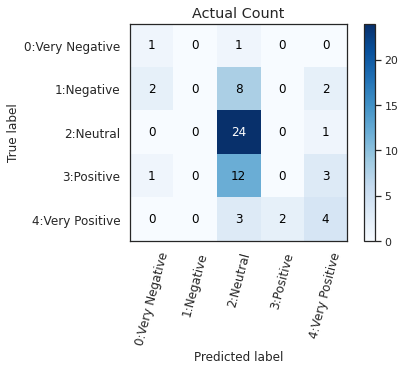

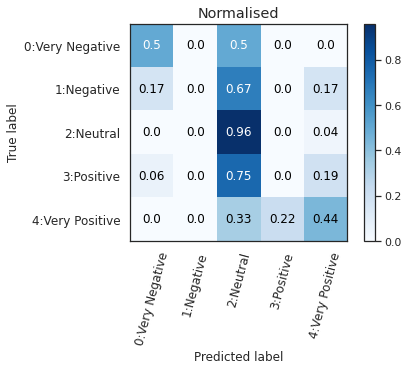

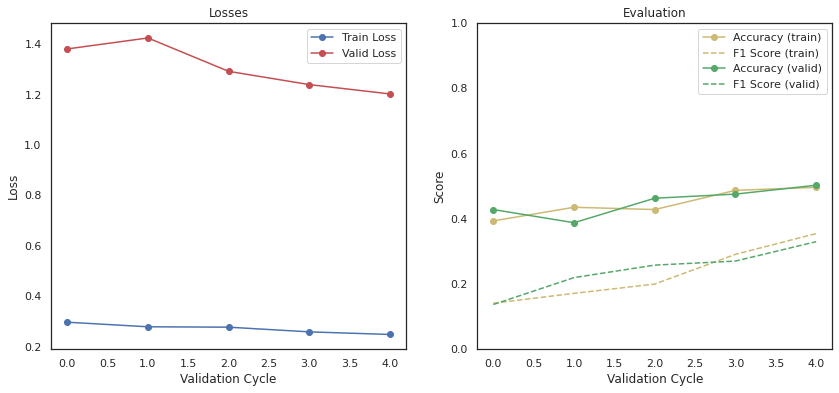

[2020-10-21 07:45:35,435][INFO] ## ================     epoch 2     ===============
[2020-10-21 07:45:37,968][DEBUG] ## Epoch: 2/5, Step: 157, Loss: 1.2013, Acc: 0.5035, F1: 0.3447
[2020-10-21 07:45:47,966][DEBUG] ## Epoch: 2/5, Step: 186, Loss: 1.1562, Acc: 0.5227, F1: 0.3830
[2020-10-21 07:45:58,547][DEBUG] ## Epoch: 2/5, Step: 217, Loss: 1.1232, Acc: 0.5433, F1: 0.4357
[2020-10-21 07:46:09,106][DEBUG] ## Epoch: 2/5, Step: 248, Loss: 1.0865, Acc: 0.5580, F1: 0.4809
[2020-10-21 07:46:19,665][DEBUG] ## Epoch: 2/5, Step: 279, Loss: 1.0553, Acc: 0.5756, F1: 0.4918
[2020-10-21 07:46:30,212][DEBUG] ## Epoch: 2/5, Step: 310, Loss: 1.0691, Acc: 0.5731, F1: 0.4883
[2020-10-21 07:46:30,704][INFO] ## epoch: 2, last train loss: 0.2091, last valid loss: 1.0691
[2020-10-21 07:46:30,705][INFO] ## last acc: 0.5731, last f1: 0.4883, best_f1: 0.3299, last lr: 0.000201


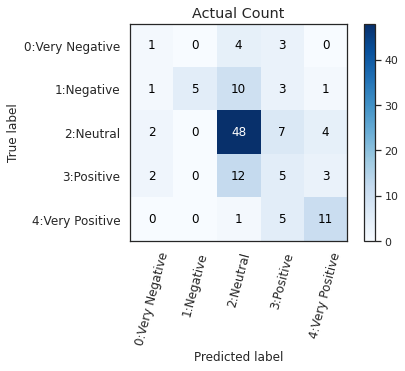

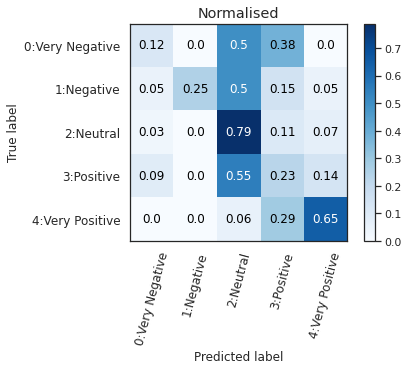

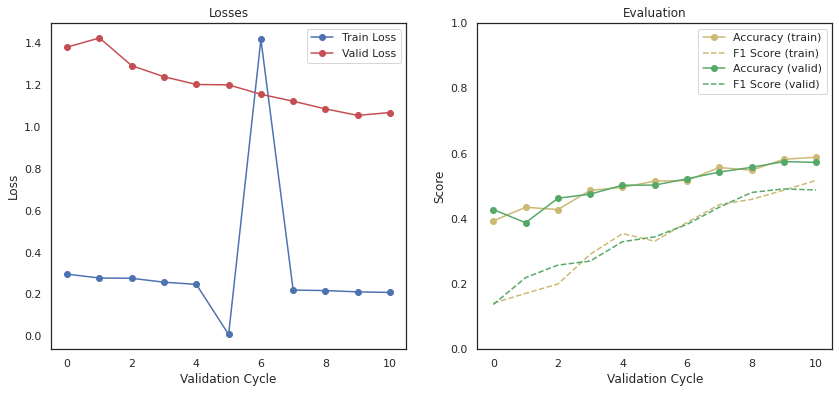

[2020-10-21 07:46:31,725][INFO] ## ================     epoch 3     ===============
[2020-10-21 07:46:41,747][DEBUG] ## Epoch: 3/5, Step: 341, Loss: 1.0713, Acc: 0.5625, F1: 0.5122
[2020-10-21 07:46:52,308][DEBUG] ## Epoch: 3/5, Step: 372, Loss: 1.0564, Acc: 0.5605, F1: 0.5086
[2020-10-21 07:47:02,882][DEBUG] ## Epoch: 3/5, Step: 403, Loss: 1.0401, Acc: 0.5741, F1: 0.5164
[2020-10-21 07:47:13,458][DEBUG] ## Epoch: 3/5, Step: 434, Loss: 1.0198, Acc: 0.5781, F1: 0.5164
[2020-10-21 07:47:24,002][DEBUG] ## Epoch: 3/5, Step: 465, Loss: 1.0094, Acc: 0.5847, F1: 0.5245
[2020-10-21 07:47:24,761][INFO] ## epoch: 3, last train loss: 0.1768, last valid loss: 1.0094
[2020-10-21 07:47:24,762][INFO] ## last acc: 0.5847, last f1: 0.5245, best_f1: 0.4883, last lr: 0.000135


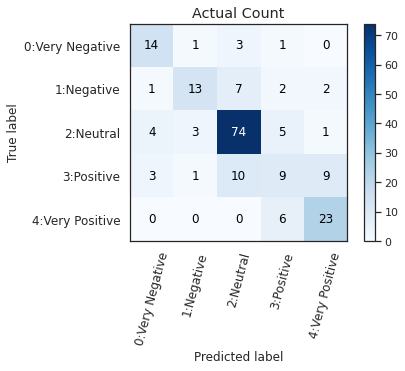

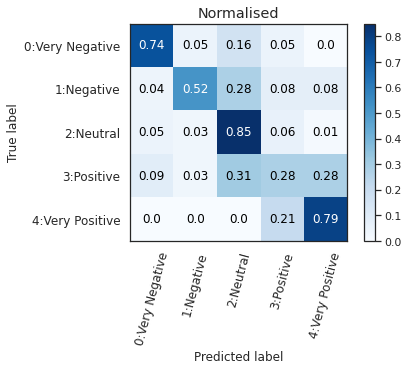

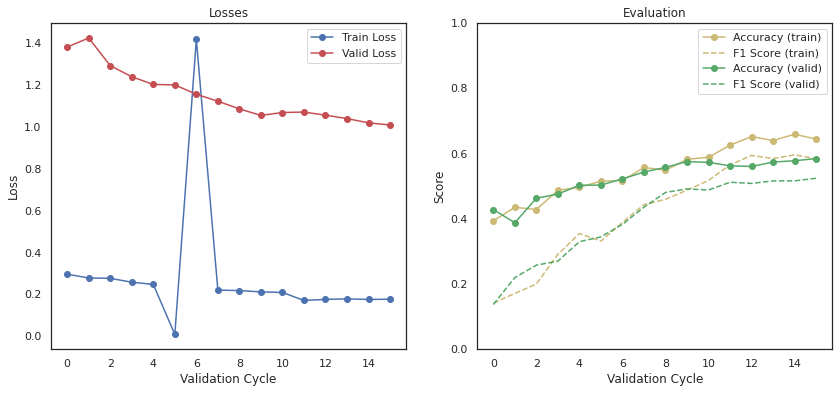

[2020-10-21 07:47:25,717][INFO] ## ================     epoch 4     ===============
[2020-10-21 07:47:35,441][DEBUG] ## Epoch: 4/5, Step: 496, Loss: 1.0918, Acc: 0.5701, F1: 0.5094
[2020-10-21 07:47:45,982][DEBUG] ## Epoch: 4/5, Step: 527, Loss: 1.1064, Acc: 0.5746, F1: 0.5207
[2020-10-21 07:47:56,578][DEBUG] ## Epoch: 4/5, Step: 558, Loss: 1.0822, Acc: 0.5837, F1: 0.5328


In [ ]:
# Define the training parameters
num_samples = [1000, 5000, 10000, 100000, 500000]
epochs=5
patience=3
batch_size=64
seq_len = 30
lr=3e-4
clip=5
log_level=logging.DEBUG

# Run!
train_cycles(train_df['text'], train_df['label'], vocab, num_samples, 'LSTM', epochs, patience, batch_size, seq_len, lr, clip, log_level)


## BERT

<table><tr><td><img src="./docs/bert_model.png" width=400></td><td><img src="./docs/transformer.png" width=550></td></tr></table>

![Comparison](./docs/bert-vs-openai-vs-elmo.png)

In [ ]:
# Use pretrained model
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

# Tokenizer Parameter
param_tk = {
    'return_tensors': "pt",
    'padding': 'max_length',
    'max_length': seq_len,
    'add_special_tokens': True,
    'truncation': True
}

In [ ]:
# Test the model and tokenizer
inputs = tokenizer_bert("Hello, my dog is cute", **param_tk)

print('inputs: \n', inputs)
print('\ndecoded: \n',tokenizer.decode(inputs['input_ids'].squeeze(0)))

labels = torch.tensor([1]).unsqueeze(0)
print('\nlabels: ', labels)

outputs = bert_model(**inputs, labels=labels)
print('\noutputs: length=', len(outputs))
print(outputs)

loss = outputs[0]
logits = outputs[1]

print('loss: ', loss.detach())
print('logits: ', logits.detach())

print(len(outputs))
print('outputs: \n',outputs)
print('outputs(detached): \n', outputs[0].detach())


### Train

In [ ]:
# Define the training parameters
num_samples = [1000, 5000, 10000, 100000, 500000]
seq_len = 30
epochs=5
patience=3
batch_size=64
lr=3e-4
clip=5
log_level=logging.DEBUG

# Run!
train_cycles(train_df['text'], train_df['label'], num_samples, 'BERT', epochs, patience, batch_size, lr, clip, log_level)


# Result

In [ ]:
# If disconnected after the training complete, just recreate the result_df rather than running the training again...
disconnected = False
if disconnected:
    n_trains = [1000, 5000, 10000, 100000, 500000]
    result_lstm = pd.DataFrame(columns=['Accuracy', 'F1(macro)', 'Total_Time'], index=n_trains)
    result_lstm.loc[1000] = (0.4115,	0.1166,	4.02131)
    result_lstm.loc[5000] = (0.4969,	0.4542,	13.189)
    result_lstm.loc[10000] = (0.5514,	0.4988,	23.8845)
    result_lstm.loc[100000] = (0.6856,	0.6548,	273.114)
    result_lstm.loc[500000] = (0.7593,	0.7375,	2704.45)

result_lstm['ms/data'] = result_lstm['Total_Time'] / result_lstm.index * 1000
result_lstm

In [ ]:
# If disconnected after the training complete, just recreate the result_df rather than running the training again...
disconnected = False
if disconnected:
    n_trains = [1000, 5000, 10000, 100000, 500000]
    result_bert = pd.DataFrame(columns=['Accuracy', 'F1(macro)', 'Total_Time'], index=n_trains)
    result_bert.loc[1000] = (0.465,	0.2876,	25.8849)
    result_bert.loc[5000] = (0.5355,	0.4475,	56.1339)
    result_bert.loc[10000] = (0.6482,	0.6039,	110.48)
    result_bert.loc[100000] = (0.7453,	0.7223,	1092.68)
    result_bert.loc[500000] = (0.7889,	0.7693,	5443.28)

result_bert['ms/data'] = result_bert['Total_Time'] / result_bert.index * 1000
result_bert

# Extra - tweet stream

In [ ]:
with open(tweet_dir + 'test_twits.json', 'r') as f:
    test_data = json.load(f)

def twit_stream():
    for twit in test_data['data']:
        yield twit

next(twit_stream())

In [ ]:
import torch.nn.functional as F

def predict(text, model, tokenizer):
    """ 
    Make a prediction on a single sentence.

    Parameters
    ----------
        text : The string to make a prediction on.
        model : The model to use for making the prediction.
        vocab : Dictionary for word to word ids. The key is the word and the value is the word id.

    Returns
    -------
        pred : Prediction vector
    """   
    text = preprocess(text)
    inputs = tokenizer(text, 
                   return_tensors="pt", 
                   padding='max_length',
                   max_length=96,
                   add_special_tokens=True,
                   truncation=True)

    outputs = model(**inputs)[0].detach()    
    pred = F.softmax(outputs, dim=1)
    
    return pred

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model.load_state_dict(torch.load(output_dir + 'stocktwit_bert.dict'))
model.eval()
model.to("cpu")

In [ ]:
# Check
text = "Google is working on self driving cars, I'm bullish on $goog"
predict(text, model, tokenizer)

In [ ]:
def score_twits(stream, model, tokenizer, universe):
    """ 
    Given a stream of twits and a universe of tickers, return sentiment scores for tickers in the universe.
    """
    class_names = ['0:Very Negative', '1:Negative', '2:Neutral', '3:Positive', '4:Very Positive']
    for twit in stream:

        # Get the message text
        text = twit['message_body']
        if len(tokenizer.tokenize(preprocess(text))) < 10:
            continue
        symbols = re.findall('\$[A-Z]{2,4}', text)
        score = predict(text, model, tokenizer)
        score = np.round(score.tolist(), 4).squeeze()
        prediction = class_names[np.argmax(score)] + " {:.1f}%".format(np.max(score)*100)

        for symbol in symbols:
            if symbol in universe:
                yield {'symbol': symbol, 'pred': prediction, 'score': score, 'text': text, 'timestamp': twit['timestamp']}

In [ ]:
# Select Universe
universe = {'$BBRY', '$AAPL', '$AMZN', '$BABA', '$YHOO', '$LQMT', '$FB', '$GOOG', '$BBBY', '$JNUG', '$SBUX', '$MU'}
score_stream = score_twits(twit_stream(), model, tokenizer, universe)

In [ ]:
# Process
for i in range(10):
    print(next(score_stream))
    i+=1